# Modelos Alternativos

**Proyecto Integrador TC5035.10**

**Profesor Asesor:**
- Dra. Ludivina Facundo (ITESM)


**Profesores Investigadores/Tutores:**
- Dr. Juan Arturo Nolazco (ITESM)
- Dr. Marcos Faunez Zaunuy (TecnoCampus Barcelona)

**Equipo 11:**
- Francisco José Arellano Montes (A01794283)
- Armando Bringas Corpus (A01200230)
- Moisés Díaz Malagón (A01208580)

**Objetivo**: Este avance implica construir múltiples modelos (individuales, no ensambles) relevantes para resolver el problema y evaluar su desempeño. Diferentes algoritmos pueden comportarse de manera óptima en diferentes tipos de datos o tareas. La construcción de modelos alternativos permite explorar y evaluar cuál de ellos proporciona el mejor rendimiento para un problema particular.

Además, los modelos se pueden ajustar para determinar si se puede mejorar su rendimiento. Diferentes configuraciones de hiperparámetros pueden afectar significativamente el rendimiento de un modelo. Construir modelos alternativos implica explorar y ajustar estos hiperparámetros para encontrar la configuración óptima.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns


from lightgbm import LGBMClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc, roc_curve, det_curve

from xgboost import XGBClassifier
import warnings

from utils import load_data, print_classification_report

In [2]:
try:
    from sklearnex import patch_sklearn
    patch_sklearn()
except ImportError:
    pass

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
warnings.filterwarnings("ignore")

# Carga de Datos

Carga inicial de los datos:

Estos datos fueron procesados en la entrega pasada, usando los mismos pasos salvo a unos cuantas modificaciones necesarias para esta entrega.

Estos datos fueron nuevamente guardados en archivos .parquet que simplemente fueron cargados para facilitar su uso en futuras integraciones.

In [4]:
X_train, y_train, X_val, y_val, X_text, y_test = load_data()

In [5]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((571, 12), (571, 3), (556, 12), (556, 3))

# Métricas

Dado que se trabajará con un 3 problemas independientes de clasificación binaria, se utilizarán las siguientes métricas, Cada métrica ayuda a evaluar el desempeño de un modelo de diferentes maneras, especialmente para problemas de clasificación:

*   **accuracy:**


$$
\text{Accuracy} = \frac{\text{Correct Predictions}}{\text{Total Predictions}}
$$


Funciona bien cuando las clases están equilibradas (igual número de muestras en cada clase).

Ejemplo: en un modelo de detección de fraude en el que el 99 % de las transacciones son normales, un modelo que prediga "no fraude" el 100 % de las veces tendría una precisión del 99 % pero sería completamente inútil.

*   **precision:**

$$
\text{Precision} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Positives (FP)}}
$$

Prioriza la reducción de Falsos Positivos (FP)

Ejemplo: la detección de spam, al marcar erróneamente un correo electrónico importante como spam es malo, lo cual da preferencia a falsos positivos.

*   **recall:**

$$
\text{Recall} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Negatives (FN)}}
$$

Prioritizes reducing False Negatives (FN)

Ejemplo: detección de cáncer; Nos preocupamos por detectar todos los casos positivos reales, incluso si eso significa permitir más falsos positivos (FP).

*   **f1:**

$$
\text{F1} = \frac{2 \times \text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
$$

Cuando necesita un equilibrio entre precisión y recall.

Ejemplo: detección de fraudes, se usan conjuntos de datos desequilibrados, donde las transacciones fraudulentas (positivas) son raras en comparación con las transacciones normales (negativas).


*   **roc_auc:**

Mide qué tan bien el modelo separa clases entre diferentes umbrales de probabilidad.

La curva ROC traza la tasa de verdaderos positivos (recuperación) frente a la tasa de falsos positivos (FPR).

# Algoritmos y entrenamiento

La detección de emociones a partir de datos textuales, como la base de datos EmoThaw, implica analizar datos no estructurados (contenido textual que carece de una estructura predefinida).

 Este tipo de datos a menudo requiere pasos de preprocesamiento como tokenización, derivación y vectorización para convertirlos en un formato estructurado adecuado para algoritmos de aprendizaje automático.

## SVM (Support Vector Machine)

### Clasificador para Depresión

In [6]:
def print_classification_report(y_true, y_pred, y_prob, label="SVM Depression"):
    print(f"{label} Classification Report:")
    print(classification_report(y_true, y_pred, zero_division=0))

    roc_auc = roc_auc_score(y_true, y_prob)
    print(f"{label} ROC AUC: {roc_auc:.4f}")

    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall, precision)
    print(f"{label} Precision-Recall AUC: {pr_auc:.4f}")

In [7]:
# Define the SVM model
svm_model = SVC(probability=True, class_weight='balanced', random_state=42)

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']  # Only relevant for RBF kernel
}

grid_search = GridSearchCV(
    svm_model, param_grid, scoring='roc_auc', cv=3, verbose=1
)

grid_search.fit(X_train, y_train['depression'])
best_svm_model = grid_search.best_estimator_

y_pred_svm = best_svm_model.predict(X_val)
y_prob_svm = best_svm_model.predict_proba(X_val)[:, 1]  # Probabilities for ROC/PR

print_classification_report(y_val['depression'], y_pred_svm, y_prob_svm)
svm_depression_best_hyperparameters = grid_search.best_params_
print("Best hyperparameters:", svm_depression_best_hyperparameters)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
SVM Depression Classification Report:
              precision    recall  f1-score   support

       False       0.71      0.24      0.36       408
        True       0.26      0.73      0.38       148

    accuracy                           0.37       556
   macro avg       0.48      0.48      0.37       556
weighted avg       0.59      0.37      0.37       556

SVM Depression ROC AUC: 0.4883
SVM Depression Precision-Recall AUC: 0.2592
Best hyperparameters: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}


Generamos nuestro modelo SVM, trabajando con nuestra etiqueta “depression” con un grid_search, al final tenemos una puntuación AUC de la curva ROC: 0.48

In [8]:
svm_poly = SVC(kernel='poly', class_weight='balanced', probability=True, random_state=42)

param_distributions = {
    'degree': [4],           # Polynomial degrees to try
    'C': [0.1, 1, 10, 100],        # Regularization strengths
    'gamma': ['scale', 'auto', 0.1, 0.01]  # Kernel coefficients
}

random_search = RandomizedSearchCV(
    svm_poly,
    param_distributions=param_distributions,
    n_iter=5,
    scoring='roc_auc',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)


random_search.fit(X_train.to_numpy(), y_train['depression'])
best_svm = random_search.best_estimator_

y_pred_poly = best_svm.predict(X_val.to_numpy())
y_prob_poly = best_svm.predict_proba(X_val.to_numpy())[:, 1]

print_classification_report(y_val['depression'], y_pred_svm, y_prob_svm)
print("Best hyperparameters:", grid_search.best_params_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
SVM Depression Classification Report:
              precision    recall  f1-score   support

       False       0.71      0.24      0.36       408
        True       0.26      0.73      0.38       148

    accuracy                           0.37       556
   macro avg       0.48      0.48      0.37       556
weighted avg       0.59      0.37      0.37       556

SVM Depression ROC AUC: 0.4883
SVM Depression Precision-Recall AUC: 0.2592
Best hyperparameters: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}


Usando algo similar, a lo anterior ahora usando un kernel tipo “poly”, una similar puntuación AUC de la curva ROC: 0.48

### Clasificador para Ansiedad

In [9]:
svm_model = SVC(probability=True, class_weight='balanced', random_state=42)

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']  # Only relevant for RBF kernel
}

grid_search = GridSearchCV(
    svm_model, param_grid, scoring='roc_auc', cv=5, verbose=1
)

grid_search.fit(X_train, y_train['anxiety'])
best_svm_model = grid_search.best_estimator_
y_pred_svm = best_svm_model.predict(X_val)
y_prob_svm = best_svm_model.predict_proba(X_val)[:, 1]  # Probabilities for ROC/PR

print_classification_report(y_val['anxiety'], y_pred_svm, y_prob_svm)
svm_anxiety_best_hyperparameters = grid_search.best_params_
print("Best hyperparameters:", svm_anxiety_best_hyperparameters)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
SVM Depression Classification Report:
              precision    recall  f1-score   support

       False       0.57      0.94      0.71       317
        True       0.49      0.08      0.13       239

    accuracy                           0.57       556
   macro avg       0.53      0.51      0.42       556
weighted avg       0.54      0.57      0.46       556

SVM Depression ROC AUC: 0.4955
SVM Depression Precision-Recall AUC: 0.4326
Best hyperparameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}


### Clasificador para Estrés

In [10]:
svm_model = SVC(probability=True, class_weight='balanced', random_state=42)

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']  # Only relevant for RBF kernel
}

grid_search = GridSearchCV(
    svm_model, param_grid, scoring='roc_auc', cv=5, verbose=1
)

grid_search.fit(X_train, y_train['stress'])
best_svm_model = grid_search.best_estimator_
y_pred_svm = best_svm_model.predict(X_val)
y_prob_svm = best_svm_model.predict_proba(X_val)[:, 1]  # Probabilities for ROC/PR

print_classification_report(y_val['stress'], y_pred_svm, y_prob_svm)
svm_stress_best_hyperparameters = grid_search.best_params_
print("Best hyperparameters:", svm_stress_best_hyperparameters)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
SVM Depression Classification Report:
              precision    recall  f1-score   support

       False       0.00      0.00      0.00       315
        True       0.43      1.00      0.60       241

    accuracy                           0.43       556
   macro avg       0.22      0.50      0.30       556
weighted avg       0.19      0.43      0.26       556

SVM Depression ROC AUC: 0.4953
SVM Depression Precision-Recall AUC: 0.4289
Best hyperparameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}


Observando la información anterior, podemos observar lo siguiente:
*   En el label de “depression”, tenemos una puntuación AUC de la curva ROC: 0.48
*   En el label de “anxiety”, tenemos una puntuación AUC de la curva ROC: 0.49
*   En el label de “stress”, tenemos una puntuación AUC de la curva ROC: 0.49

## XGBoost

### Clasificador para Depresión

In [11]:
# imbalance ratio
imbalance_ratio_depression = len(y_train['depression'][y_train['depression'] == 0]) / len(y_train['depression'][y_train['depression'] == 1])

In [12]:
# Initialize XGBoost with imbalance handling
xgb_model = XGBClassifier(scale_pos_weight=imbalance_ratio_depression, random_state=42)

# Train on depression classification
xgb_model.fit(X_train, y_train['depression'])

# Predict on validation set
y_pred_xgb = xgb_model.predict(X_val)
y_prob_xgb = xgb_model.predict_proba(X_val)[:, 1]

# Evaluate performance
print("XGBoost Depression Classification Report:")
print(classification_report(y_val['depression'], y_pred_xgb))
print("XGBoost Depression ROC AUC:", roc_auc_score(y_val['depression'], y_prob_xgb))

XGBoost Depression Classification Report:
              precision    recall  f1-score   support

       False       0.74      0.35      0.48       408
        True       0.27      0.66      0.38       148

    accuracy                           0.43       556
   macro avg       0.50      0.50      0.43       556
weighted avg       0.61      0.43      0.45       556

XGBoost Depression ROC AUC: 0.5075268282988871


Generamos nuestro modelo clasificador xgb, obteniendo un relación de desequilibrio, trabajando con nuestra etiqueta “depression”, al final tenemos una puntuación AUC de la curva ROC: 0.50

In [13]:
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_depth': [3, 5, 7],  # Tree depth
    'learning_rate': [0.01, 0.1, 0.3],  # Step size
    'scale_pos_weight': [imbalance_ratio_depression]  # Imbalance handling
}

xgb_tuned = XGBClassifier(random_state=42)

grid_search = GridSearchCV(xgb_tuned, param_grid, scoring='roc_auc', cv=3, verbose=1)
grid_search.fit(X_train, y_train['depression'])

best_xgb = grid_search.best_estimator_

y_pred_xgb_tuned = best_xgb.predict(X_val)
y_prob_xgb_tuned = best_xgb.predict_proba(X_val)[:, 1]

print_classification_report(y_val['depression'], y_pred_xgb_tuned, y_prob_xgb_tuned, label="XGBoost Depression")
xgboost_depression_best_hyperparameters = grid_search.best_params_
print("Best Hyperparameters:", xgboost_depression_best_hyperparameters)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
XGBoost Depression Classification Report:
              precision    recall  f1-score   support

       False       0.79      0.04      0.07       408
        True       0.27      0.97      0.42       148

    accuracy                           0.29       556
   macro avg       0.53      0.50      0.25       556
weighted avg       0.65      0.29      0.16       556

XGBoost Depression ROC AUC: 0.5145
XGBoost Depression Precision-Recall AUC: 0.3261
Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'scale_pos_weight': 2.7320261437908497}


Similar al modelo anterior, ahora aplicando un grid_search y entrenando el mejor modelo tenemos al final tenemos una puntuación AUC de la curva ROC: 0.51

### Clasificador para Ansiedad

In [14]:
# imbalance ratio
imbalance_ratio_anxiety = len(y_train['anxiety'][y_train['anxiety'] == 0]) / len(y_train['anxiety'][y_train['anxiety'] == 1])

In [15]:
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_depth': [3, 5, 7],  # Tree depth
    'learning_rate': [0.01, 0.1, 0.3],  # Step size
    'scale_pos_weight': [imbalance_ratio_anxiety]  # Imbalance handling
}

xgb_tuned = XGBClassifier(random_state=42)

grid_search = GridSearchCV(xgb_tuned, param_grid, scoring='roc_auc', cv=3, verbose=1)
grid_search.fit(X_train, y_train['anxiety'])

best_xgb = grid_search.best_estimator_

y_pred_xgb_tuned = best_xgb.predict(X_val)
y_prob_xgb_tuned = best_xgb.predict_proba(X_val)[:, 1]

print_classification_report(y_val['anxiety'], y_pred_xgb_tuned, y_prob_xgb_tuned, label="XGBoost Anxiety")
xgboost_anxiety_best_hyperparameters = grid_search.best_params_
print("Best Hyperparameters:", xgboost_anxiety_best_hyperparameters)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
XGBoost Anxiety Classification Report:
              precision    recall  f1-score   support

       False       0.63      0.19      0.29       317
        True       0.44      0.85      0.58       239

    accuracy                           0.47       556
   macro avg       0.54      0.52      0.44       556
weighted avg       0.55      0.47      0.42       556

XGBoost Anxiety ROC AUC: 0.5171
XGBoost Anxiety Precision-Recall AUC: 0.5103
Best Hyperparameters: {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 50, 'scale_pos_weight': 1.3024193548387097}


### Clasificador para Estrés

In [16]:
# imbalance ratio
imbalance_ratio_stress = len(y_train['stress'][y_train['stress'] == 0]) / len(y_train['stress'][y_train['stress'] == 1])

In [17]:
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_depth': [3, 5, 7],  # Tree depth
    'learning_rate': [0.01, 0.1, 0.3],  # Step size
    'scale_pos_weight': [imbalance_ratio_anxiety]  # Imbalance handling
}

xgb_tuned = XGBClassifier(random_state=42)

grid_search = GridSearchCV(xgb_tuned, param_grid, scoring='roc_auc', cv=3, verbose=1)
grid_search.fit(X_train, y_train['stress'])

best_xgb = grid_search.best_estimator_

y_pred_xgb_tuned = best_xgb.predict(X_val)
y_prob_xgb_tuned = best_xgb.predict_proba(X_val)[:, 1]

print_classification_report(y_val['stress'], y_pred_xgb_tuned, y_prob_xgb_tuned, label="XGBoost Stress")
xgboost_stress_best_hyperparameters = grid_search.best_params_
print("Best Hyperparameters:", xgboost_stress_best_hyperparameters)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
XGBoost Stress Classification Report:
              precision    recall  f1-score   support

       False       0.56      0.92      0.70       315
        True       0.38      0.07      0.11       241

    accuracy                           0.55       556
   macro avg       0.47      0.49      0.41       556
weighted avg       0.48      0.55      0.44       556

XGBoost Stress ROC AUC: 0.5036
XGBoost Stress Precision-Recall AUC: 0.4376
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'scale_pos_weight': 1.3024193548387097}


Observando la información anterior, podemos observar lo siguiente:
*   En el label de “depression”, tenemos una puntuación AUC de la curva ROC: 0.51
*   En el label de “anxiety”, tenemos una puntuación AUC de la curva ROC: 0.51
*   En el label de “stress”, tenemos una puntuación AUC de la curva ROC: 0.50

## LightGBM

### Clasificador para Depresión

In [18]:
lgbm_model = LGBMClassifier(class_weight='balanced', random_state=42, verbose=-1)
lgbm_model.fit(X_train, y_train['depression'])

y_pred_lgbm = lgbm_model.predict(X_val)
y_prob_lgbm = lgbm_model.predict_proba(X_val)[:, 1]

print("LightGBM Depression Classification Report:")
print(classification_report(y_val['depression'], y_pred_lgbm))
print("LightGBM Depression ROC AUC:", roc_auc_score(y_val['depression'], y_prob_lgbm))

LightGBM Depression Classification Report:
              precision    recall  f1-score   support

       False       0.72      0.42      0.53       408
        True       0.26      0.55      0.35       148

    accuracy                           0.45       556
   macro avg       0.49      0.49      0.44       556
weighted avg       0.60      0.45      0.48       556

LightGBM Depression ROC AUC: 0.49295343137254904


Generamos nuestro modelo clasificador xgb, obteniendo un relación de desequilibrio, trabajando con nuestra etiqueta “depression”, al final tenemos una puntuación AUC de la curva ROC: 0.50

In [19]:
param_grid = {
    'num_leaves': [20, 50, 100],  # Increase to capture complexity
    'learning_rate': [0.01, 0.1, 0.3],  # Adjust step size
    'min_child_samples': [5, 10, 20],  # Control leaf creation
    'class_weight': ['balanced']
}

grid_search = GridSearchCV(LGBMClassifier(random_state=42, verbose=-1), param_grid, scoring='roc_auc', cv=3, verbose=1)
grid_search.fit(X_train, y_train['depression'])

best_lgbm = grid_search.best_estimator_

y_pred_lgbm_tuned = best_lgbm.predict(X_val)
y_prob_lgbm_tuned = best_lgbm.predict_proba(X_val)[:, 1]

print_classification_report(y_val['depression'], y_pred_xgb_tuned, y_prob_xgb_tuned, label="XGBoost Depression")
lightGBM_depression_best_hyperparameters = grid_search.best_params_
print("Best Hyperparameters:", lightGBM_depression_best_hyperparameters)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
XGBoost Depression Classification Report:
              precision    recall  f1-score   support

       False       0.74      0.93      0.82       408
        True       0.29      0.08      0.13       148

    accuracy                           0.70       556
   macro avg       0.51      0.50      0.47       556
weighted avg       0.62      0.70      0.64       556

XGBoost Depression ROC AUC: 0.4902
XGBoost Depression Precision-Recall AUC: 0.2790
Best Hyperparameters: {'class_weight': 'balanced', 'learning_rate': 0.01, 'min_child_samples': 20, 'num_leaves': 20}


Similar al modelo anterior, ahora aplicando un grid_search y entrenando el mejor modelo tenemos al final tenemos una puntuación AUC de la curva ROC: 0.51

### Clasificador para Ansiedad

In [20]:
param_grid = {
    'num_leaves': [20, 50, 100],  # Increase to capture complexity
    'learning_rate': [0.01, 0.1, 0.3],  # Adjust step size
    'min_child_samples': [5, 10, 20],  # Control leaf creation
    'class_weight': ['balanced']
}

grid_search = GridSearchCV(LGBMClassifier(random_state=42, verbose=-1), param_grid, scoring='roc_auc', cv=3, verbose=1)
grid_search.fit(X_train, y_train['anxiety'])

best_lgbm = grid_search.best_estimator_

y_pred_lgbm_tuned = best_lgbm.predict(X_val)
y_prob_lgbm_tuned = best_lgbm.predict_proba(X_val)[:, 1]

print_classification_report(y_val['anxiety'], y_pred_xgb_tuned, y_prob_xgb_tuned, label="XGBoost Anxiety")
lightGBM_anxiety_best_hyperparameters = grid_search.best_params_
print("Best Hyperparameters:", lightGBM_anxiety_best_hyperparameters)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
XGBoost Anxiety Classification Report:
              precision    recall  f1-score   support

       False       0.57      0.93      0.71       317
        True       0.48      0.08      0.14       239

    accuracy                           0.57       556
   macro avg       0.53      0.51      0.43       556
weighted avg       0.53      0.57      0.47       556

XGBoost Anxiety ROC AUC: 0.5125
XGBoost Anxiety Precision-Recall AUC: 0.4618
Best Hyperparameters: {'class_weight': 'balanced', 'learning_rate': 0.3, 'min_child_samples': 5, 'num_leaves': 20}


### Clasificador para Estrés

In [21]:
param_grid = {
    'num_leaves': [20, 50, 100],  # Increase to capture complexity
    'learning_rate': [0.01, 0.1, 0.3],  # Adjust step size
    'min_child_samples': [5, 10, 20],  # Control leaf creation
    'class_weight': ['balanced']
}

grid_search = GridSearchCV(LGBMClassifier(random_state=42, verbose=-1), param_grid, scoring='roc_auc', cv=3, verbose=1)
grid_search.fit(X_train, y_train['stress'])

best_lgbm = grid_search.best_estimator_

y_pred_lgbm_tuned = best_lgbm.predict(X_val)
y_prob_lgbm_tuned = best_lgbm.predict_proba(X_val)[:, 1]

print_classification_report(y_val['stress'], y_pred_xgb_tuned, y_prob_xgb_tuned, label="XGBoost Stress")
lightGBM_stress_best_hyperparameters = grid_search.best_params_
print("Best Hyperparameters:", lightGBM_stress_best_hyperparameters)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
XGBoost Stress Classification Report:
              precision    recall  f1-score   support

       False       0.56      0.92      0.70       315
        True       0.38      0.07      0.11       241

    accuracy                           0.55       556
   macro avg       0.47      0.49      0.41       556
weighted avg       0.48      0.55      0.44       556

XGBoost Stress ROC AUC: 0.5036
XGBoost Stress Precision-Recall AUC: 0.4376
Best Hyperparameters: {'class_weight': 'balanced', 'learning_rate': 0.3, 'min_child_samples': 10, 'num_leaves': 50}


Observando la información anterior, podemos observar lo siguiente:
*   En el label de “depression”, tenemos una puntuación AUC de la curva ROC: 0.49
*   En el label de “anxiety”, tenemos una puntuación AUC de la curva ROC: 0.51
*   En el label de “stress”, tenemos una puntuación AUC de la curva ROC: 0.50

En el contexto de la detección de emociones a partir de datos textuales, los estudios han demostrado la eficacia de estos algoritmos:

*   Un estudio sobre el análisis de datos de sensores para el reconocimiento de
emociones logró una tasa de reconocimiento del 92,5 % utilizando XGBoost y LightGBM para nueve clases de emociones diferentes. [1]

## Multi layer perceptron (MLP)

## Long Short-Term Memory (LSTM)

## Convolutional Neural Network (CNN)

# Selección de mejores modelos

#### Graficas de la curva ROC y DET de modelos con etiqueta de “Depression”

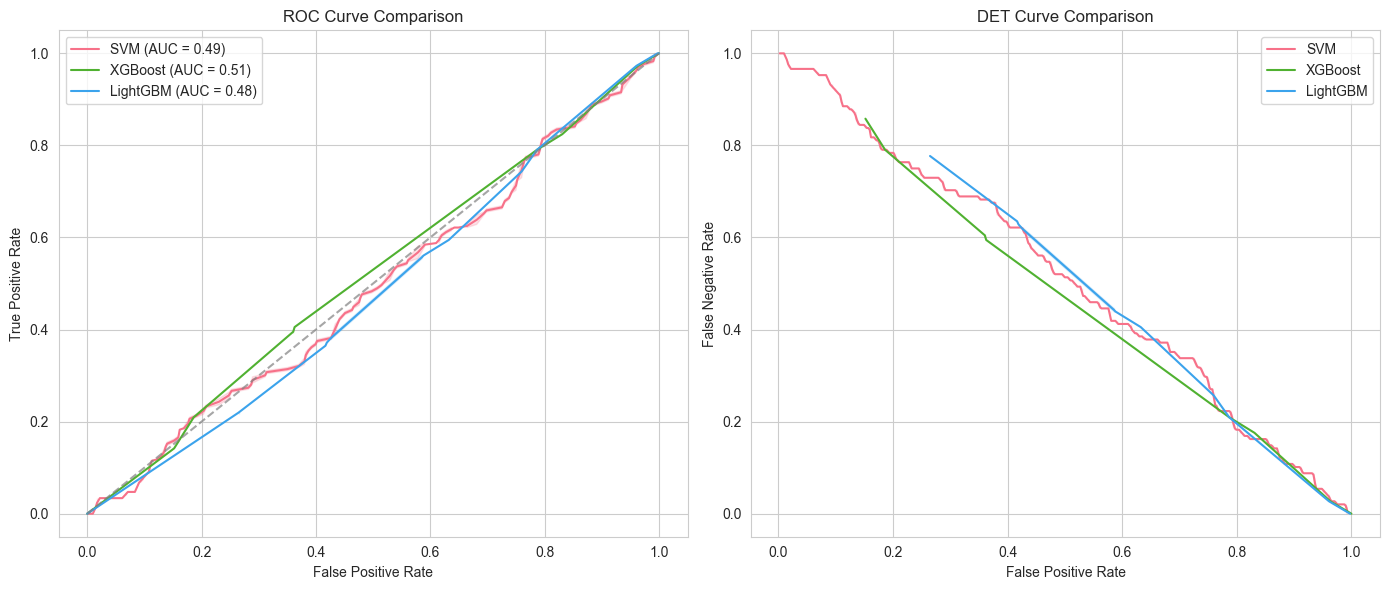

In [22]:
models = {
    "SVM": SVC(**svm_depression_best_hyperparameters, probability=True, class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(**xgboost_depression_best_hyperparameters, random_state=42),
    "LightGBM": LGBMClassifier(**lightGBM_depression_best_hyperparameters, random_state=42)
}

plt.figure(figsize=(14, 6))
palette = sns.color_palette("husl", len(models))
models_list_depression = []

for i, (name, model) in enumerate(models.items()):
    model.fit(X_train, y_train['depression'])
    y_prob = model.predict_proba(X_val)[:, 1]
    fpr, tpr, _ = roc_curve(y_val['depression'], y_prob)
    fpr_det, fnr_det, _ = det_curve(y_val['depression'], y_prob)

    models_list_depression.append(model)

    plt.subplot(1, 2, 1)
    sns.lineplot(x=fpr, y=tpr, label=f"{name} (AUC = {roc_auc_score(y_val['depression'], y_prob):.2f})",
                 color=palette[i])

    plt.subplot(1, 2, 2)
    sns.lineplot(x=fpr_det, y=fnr_det, label=name, color=palette[i])

plt.subplot(1, 2, 1)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", alpha=0.7)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()

plt.subplot(1, 2, 2)
plt.xlabel("False Positive Rate")
plt.ylabel("False Negative Rate")
plt.title("DET Curve Comparison")
plt.legend()

plt.tight_layout()
plt.show()


Perspectivas de la curva ROC:

Puntuaciones AUC (0,49–0,51): los modelos funcionan sólo ligeramente mejor que las conjeturas aleatorias, lo que indica una falta de características predictivas sólidas.

Rendimiento consistente en todos los modelos: ningún modelo supera significativamente a los demás

Información sobre la curva DET:

Las curvas DET muestran que las mejoras en FPR no mejoran drásticamente la FNR, lo que sugiere que los modelos están luchando con límites de decisión claros.


Guardamos la lista de la etiqueta “depression” para la siguiente sección.

In [23]:
models_list_depression

[SVC(C=10, class_weight='balanced', kernel='linear', probability=True,
     random_state=42),
 XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.01, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=3, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=50, n_jobs=None,
               num_parallel_tree=None, random_state=42, ...),
 LGBMClassifier(class_weight='balanced', learning_rate=0.01, num_leaves=20,
                random_state=42)]

#### Graficas de la curva ROC y DET de modelos con etiqueta de “Anxiety”

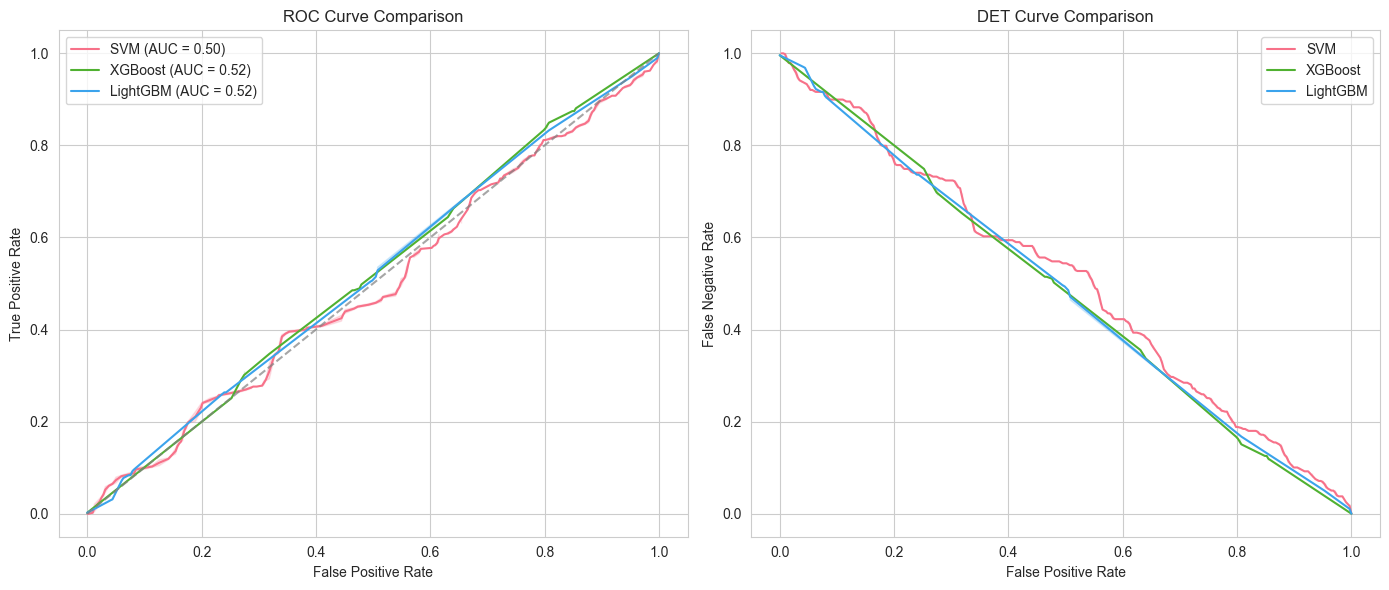

In [24]:
models = {
    "SVM": SVC(**svm_anxiety_best_hyperparameters, probability=True, class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(**xgboost_anxiety_best_hyperparameters, random_state=42),
    "LightGBM": LGBMClassifier(**lightGBM_anxiety_best_hyperparameters, random_state=42)
}

plt.figure(figsize=(14, 6))
palette = sns.color_palette("husl", len(models))
models_list_anxiety = []

for i, (name, model) in enumerate(models.items()):
    model.fit(X_train, y_train['anxiety'])
    y_prob = model.predict_proba(X_val)[:, 1]
    fpr, tpr, _ = roc_curve(y_val['anxiety'], y_prob)
    fpr_det, fnr_det, _ = det_curve(y_val['anxiety'], y_prob)

    models_list_anxiety.append(model)

    plt.subplot(1, 2, 1)
    sns.lineplot(x=fpr, y=tpr, label=f"{name} (AUC = {roc_auc_score(y_val['anxiety'], y_prob):.2f})",
                 color=palette[i])

    plt.subplot(1, 2, 2)
    sns.lineplot(x=fpr_det, y=fnr_det, label=name, color=palette[i])

plt.subplot(1, 2, 1)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", alpha=0.7)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()

plt.subplot(1, 2, 2)
plt.xlabel("False Positive Rate")
plt.ylabel("False Negative Rate")
plt.title("DET Curve Comparison")
plt.legend()

plt.tight_layout()
plt.show()


Perspectivas de la curva ROC:

AUC ligeramente superior (~0,50–0,51): aunque todavía son débiles, los modelos de ansiedad muestran una separación de clases ligeramente mejor en comparación con la depresión.

Los modelos basados en árboles funcionan ligeramente mejor: XGBoost y LightGBM tienen AUC más altas que la regresión logística y SVM, lo que sugiere que existen relaciones no lineales en los datos.

Información sobre la curva DET:

tasas de falsos positivos y falsos negativos se distribuyen de manera más uniforme, comparada con la grafica anterior en el label “depression”.


#### Graficas de la curva ROC y DET de modelos con etiqueta de "Stress"

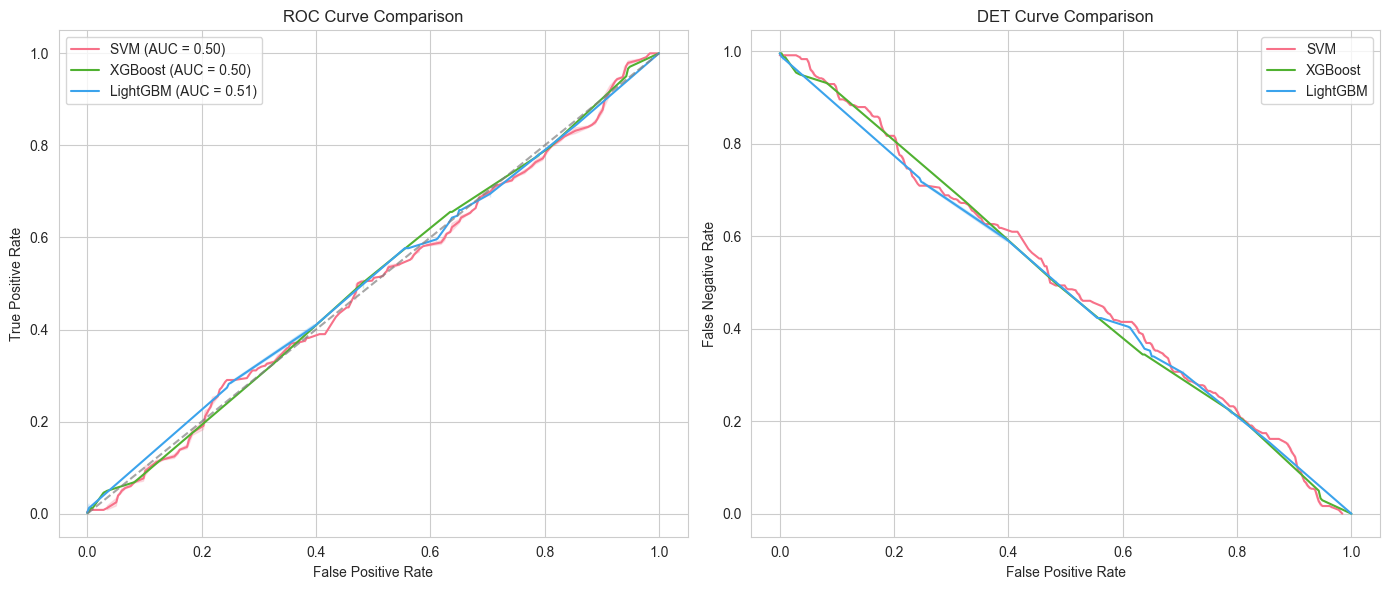

In [25]:
models = {
    "SVM": SVC(**svm_stress_best_hyperparameters, probability=True, class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(**xgboost_stress_best_hyperparameters, random_state=42),
    "LightGBM": LGBMClassifier(**lightGBM_stress_best_hyperparameters, random_state=42)
}

plt.figure(figsize=(14, 6))
palette = sns.color_palette("husl", len(models))
models_list_stress = []

for i, (name, model) in enumerate(models.items()):
    model.fit(X_train, y_train['stress'])
    y_prob = model.predict_proba(X_val)[:, 1]
    fpr, tpr, _ = roc_curve(y_val['stress'], y_prob)
    fpr_det, fnr_det, _ = det_curve(y_val['stress'], y_prob)

    models_list_stress.append(model)

    plt.subplot(1, 2, 1)
    sns.lineplot(x=fpr, y=tpr, label=f"{name} (AUC = {roc_auc_score(y_val['stress'], y_prob):.2f})",
                 color=palette[i])

    plt.subplot(1, 2, 2)
    sns.lineplot(x=fpr_det, y=fnr_det, label=name, color=palette[i])

plt.subplot(1, 2, 1)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", alpha=0.7)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()

plt.subplot(1, 2, 2)
plt.xlabel("False Positive Rate")
plt.ylabel("False Negative Rate")
plt.title("DET Curve Comparison")
plt.legend()

plt.tight_layout()
plt.show()


Perspectivas de la curva ROC:

AUC similar a la ansiedad (~0,50–0,51): los modelos funcionan ligeramente mejor que las conjeturas aleatorias, pero aún carecen de un fuerte poder predictivo.

No hay un modelo destacado: a diferencia de la ansiedad, donde los modelos basados en árboles mejoraron ligeramente los resultados, todos los modelos parecen funcionar de manera similar para la detección del estrés.

Regresión logística y SVM bajan ligeramente en rendimiento.

Información sobre la curva DET:

Posible limitación del conjunto de datos: si ningún modelo mejora significativamente los resultados, es posible que las funciones no capturen patrones relacionados con el estrés de manera efectiva.


# Ajuste de Hiperparámetros de los mejores modelos

# Selección de mejor modelo

# Conclusiones

Lorem ipsum

# Referencias

S, G., Anand, A., Vijayvargiya, A., M, P., Moorthy, V., Kumar, S., & S, H. B. S. (2022, July 12). Emosens: Emotion recognition based on sensor data analysis using LIGHTGBM. arXiv.org. https://arxiv.org/abs/2207.14640

Costa, R. (2022). The CRISP-ML Methodology: A Step-by-Step Approach to Real-World Machine Learning Projects.

Piccini, N. (2023, julio 19). 101 machine learning algorithms for data science with cheat sheets. Data Science Dojo.